In [2]:
import numpy as np
import pylab as plt
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc.prior
from pyabc.plots import plot_marginals, plot_particles, plot_pairs
%matplotlib notebook

## Intractable model by Tanaka et al. 2006 for spread of tuberculosis

![](img/transmission_process.png)

### model parameter
$\alpha$: rate with which each infectious host randomly infects other individuals from an unlimited supply of hosts

$\delta$: rate with which a host stops being infectious, either by recovering or dying

$\tau$: rate with which the pathogen of the host mutates randomly within the host, generating a novel haplotype under a single-locus infinite alleles model

$\theta = (\alpha, \delta, \tau)$

$y_{\theta} = (6,3,2,2,1,1,1,1,1,1,1)$: output, vector of clusters, that is different haplotypes. Each number represents the infectious hosts for this particular haplotype

### Observation
$\alpha = 0.2, \delta = 0, \tau = 0.198, m = 20$

assume, that $\delta, \tau$ are known and apply uniform prior

In [3]:
alpha = 0.2
delta = 0.1
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.1, 1, name="alpha")
prior_tau = pyabc.Prior("uniform", 0.01, 1, name="tau")

simulator = tuberculosis.simulator

In [4]:
min(prior_alpha.sample(10000))

array([ 0.10000235])

In [5]:
# for i in range(100):
#     params = [prior_alpha.sample(),prior_delta.sample(),prior_tau.sample()]
#     y0 = simulator(*params)

params = [alpha, tau]

y0 = simulator(*params)
y0

array([6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [6]:
list_of_sum = tuberculosis.summaries
for f in list_of_sum:
    print(f.__name__)
    print(f(y0))
    
#summaries = tuberculosis.summaries
summaries = [lambda x: x]

nr_mutations
20
max_cluster
6
nr_transmissions
2


In [7]:
# in this cell, I tested why the 'identity' summary statistic makes problems
from pyabc.utils import flatten_function
from pyabc.prior import PriorList

p = PriorList([prior_alpha])
thetas = p.sample(2)

sim_a = lambda alpha: simulator(alpha, 0.2, 0.1)

simulate_and_summarize = lambda thetas: flatten_function(summaries, sim_a(*thetas))
np.apply_along_axis(simulate_and_summarize, axis=1, arr=thetas)
#simulate_and_summarize(params).shape

array([[ 4.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 8.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

### ABC with summary stats

In [8]:
rej = pyabc.RejectionSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337, verbosity=1)
smc = pyabc.SMCSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337)
mcmc = pyabc.MCMCSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337)
abcde = pyabc.ABCDESampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337)

In [9]:
rej.sample(nr_samples=1000, threshold=1.2)

Rejection sampler started with threshold: 1.2 and number of samples: 1000
Samples:   1000 - Threshold: 1.2000 - Iterations:     133000 - Acceptance rate: 0.007519 - Time:    87.53 s


In [10]:
smc.sample(nr_samples=1000, thresholds=np.linspace(2, 1, 5))

SMC sampler started with thresholds: [ 2.    1.75  1.5   1.25  1.  ] and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
starting iteration[ 4 ]
Iteration 4 completed
Samples:   1000 - Thresholds: 1.00 - Iterations:     175903 - Acceptance rate: 0.005685 - Time:   292.86 s


In [11]:
mcmc.sample(nr_samples=1000, threshold=2, step_size = [0.1, 0.1])

MCMC sampler started with threshold: 2 and number of samples: 1000
Samples:   1000 - Threshold: 2.0000 - Iterations:       7640 - Acceptance rate: 0.130890 - Time:    10.87 s


In [12]:
abcde.sample(nr_samples=500, nr_groups = 10, nr_iter = 100, burn_in = 100, alpha = 0.0, beta = 0.0, kappa = 0.9)

ABC-Differential-Evolution sampler started with number of samples: 500
initializing pools
Samples:    500 - Iterations:        100 - Acceptance rate: None - Time:   155.05 s


<IPython.core.display.Javascript object>


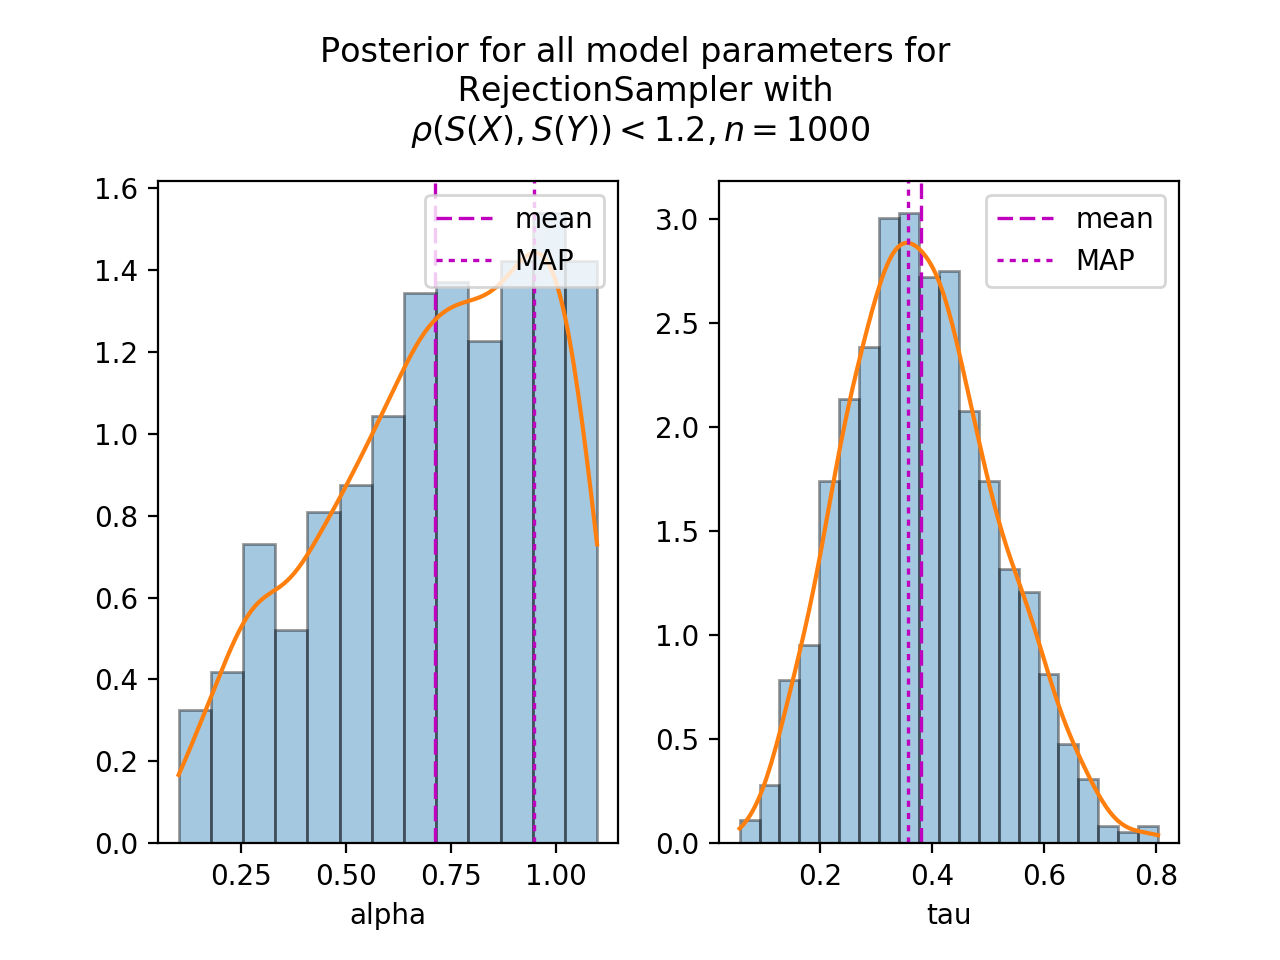

<IPython.core.display.Javascript object>


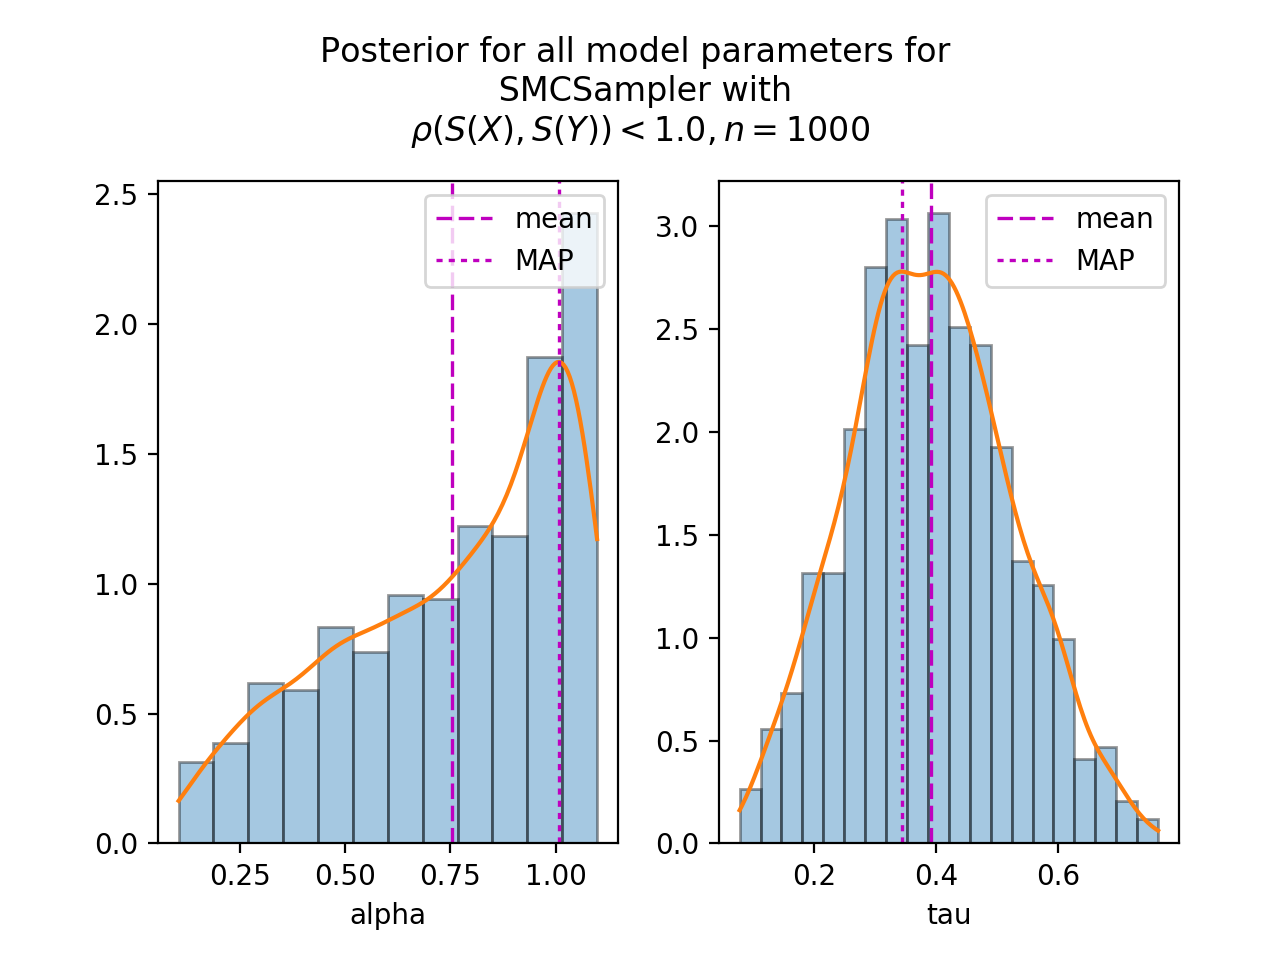

<IPython.core.display.Javascript object>


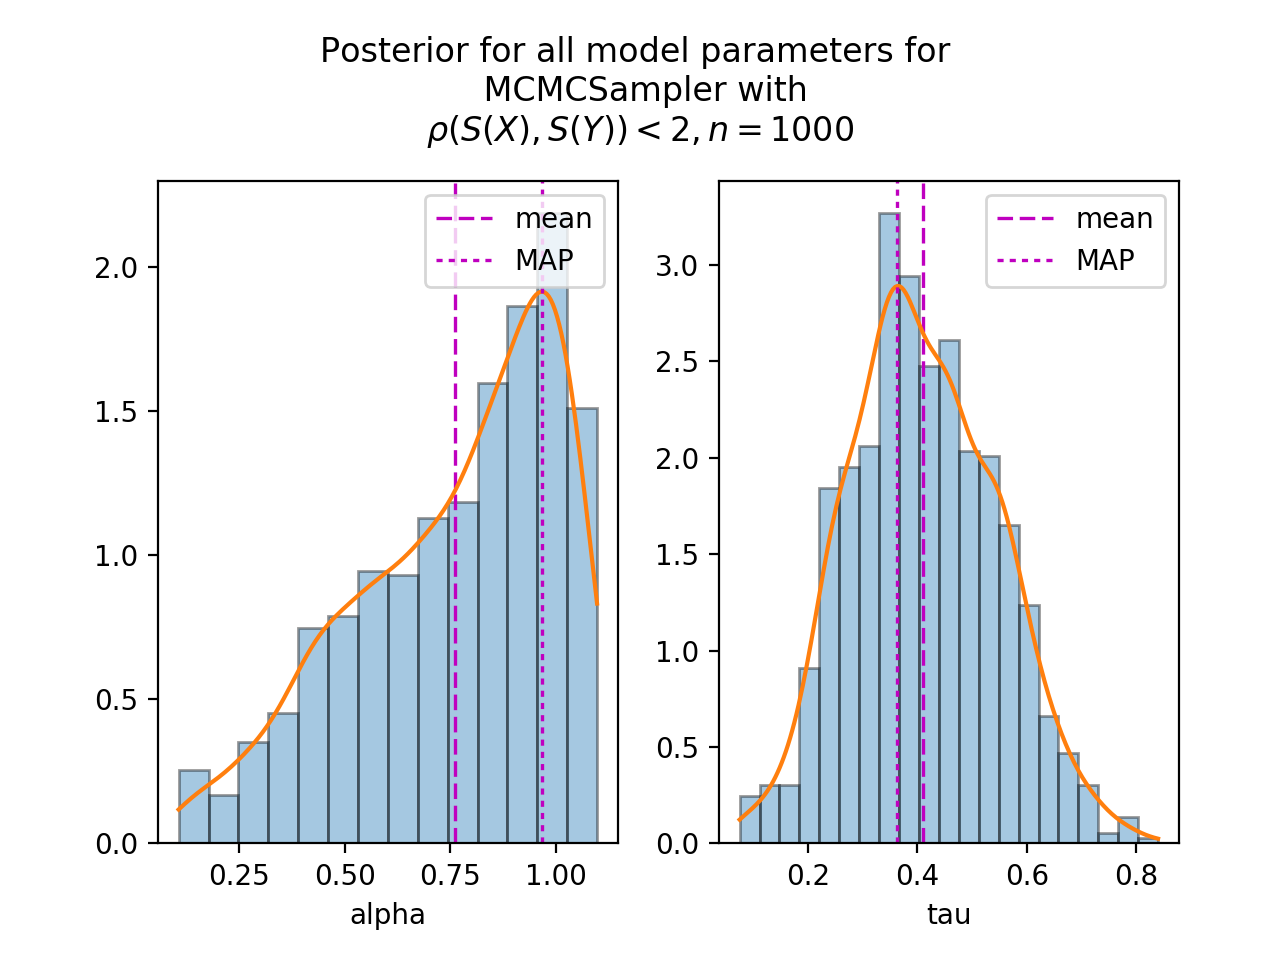

<IPython.core.display.Javascript object>


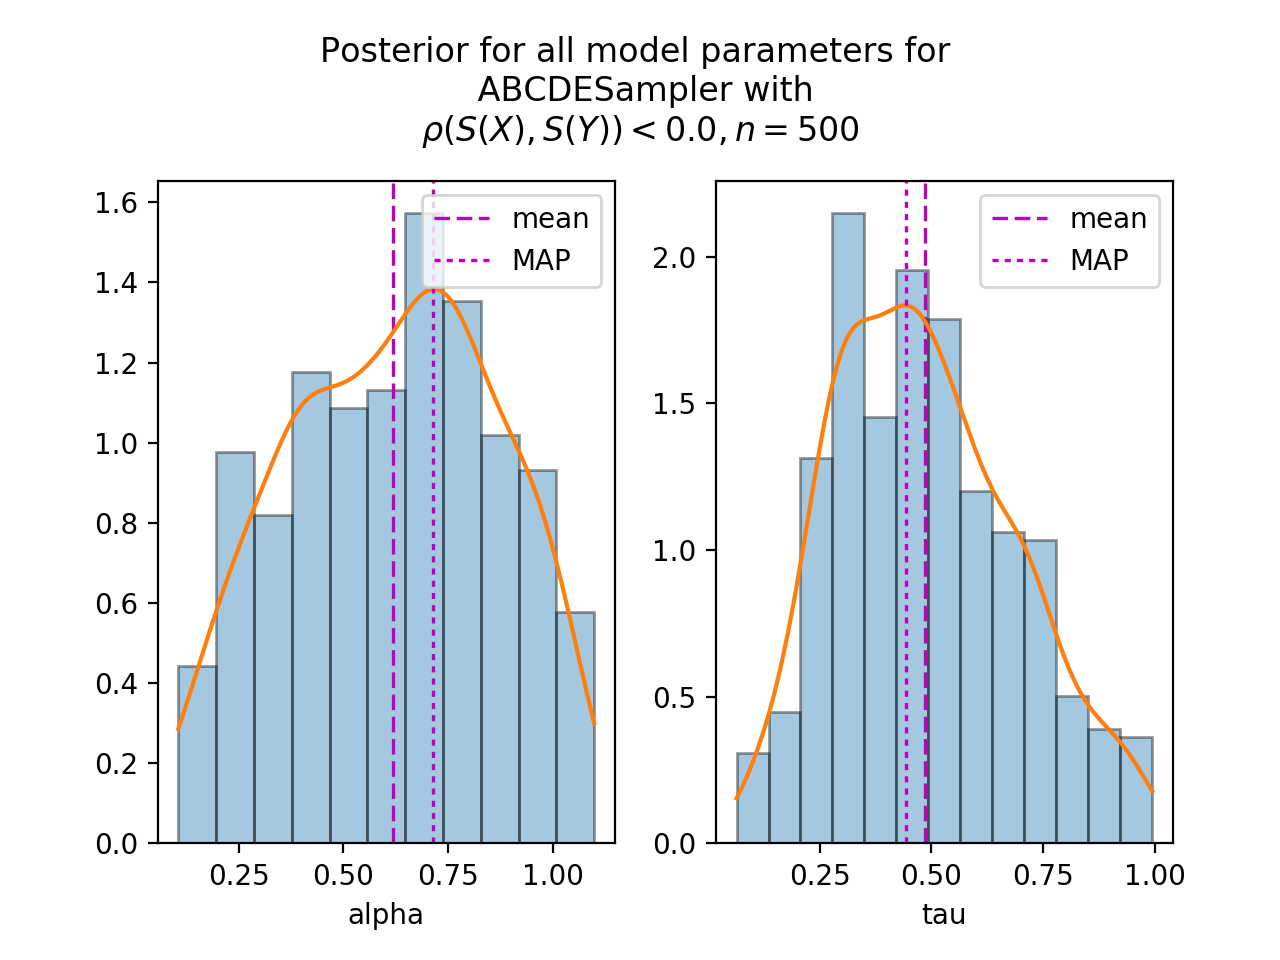

<IPython.core.display.Javascript object>


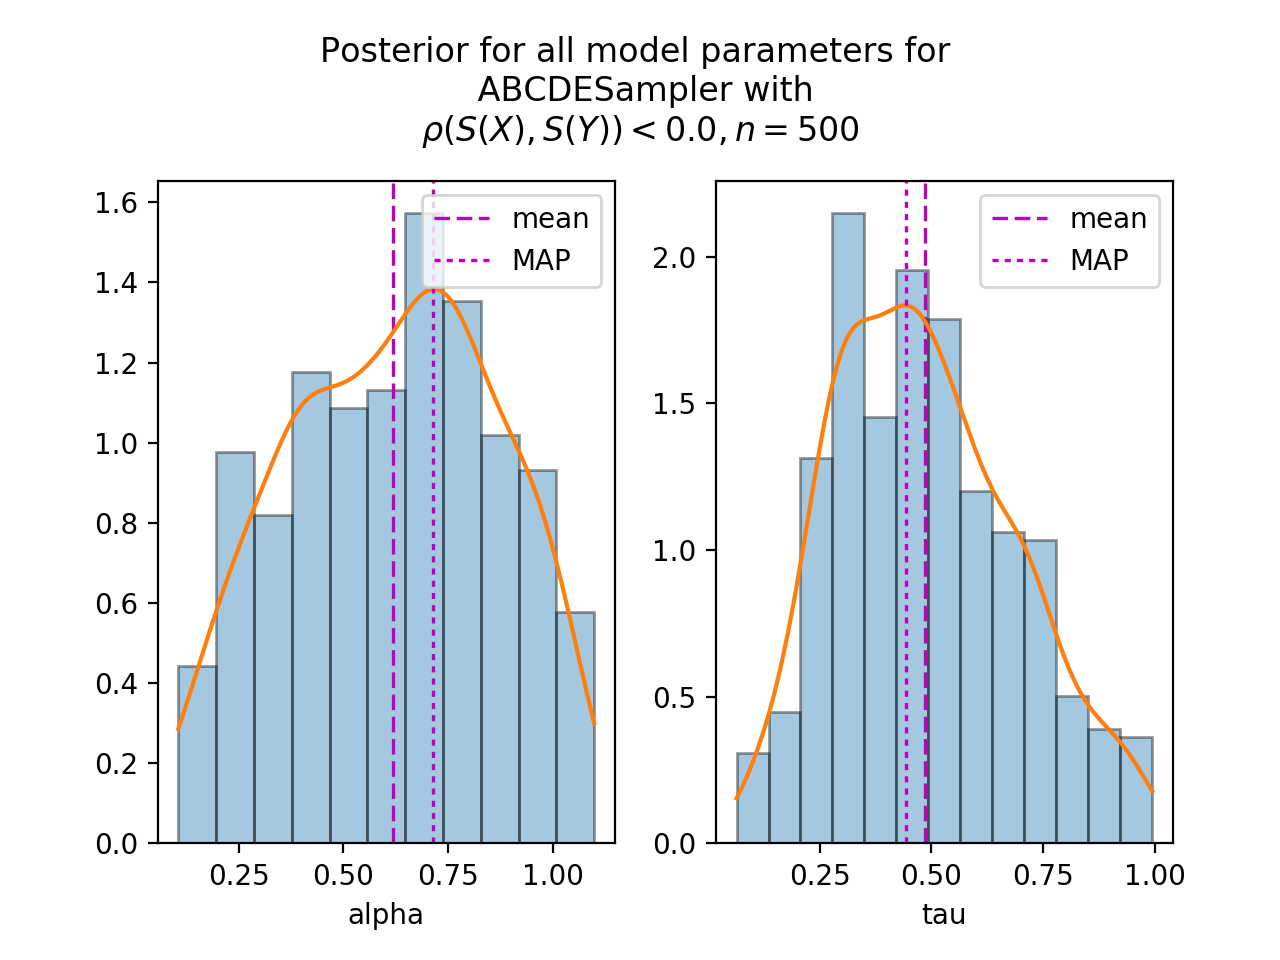

In [13]:
plot_marginals(rej, kde=True, normed=True)
plot_marginals(smc, kde=True, normed=True)
plot_marginals(mcmc, kde=True, normed=True)
plot_marginals(abcde, kde=True, normed=True)
#plot_marginals(bolfi, kde=True, normed=True)

In [ ]:
plot_marginals(smc, plot_all=True)

<IPython.core.display.Javascript object>


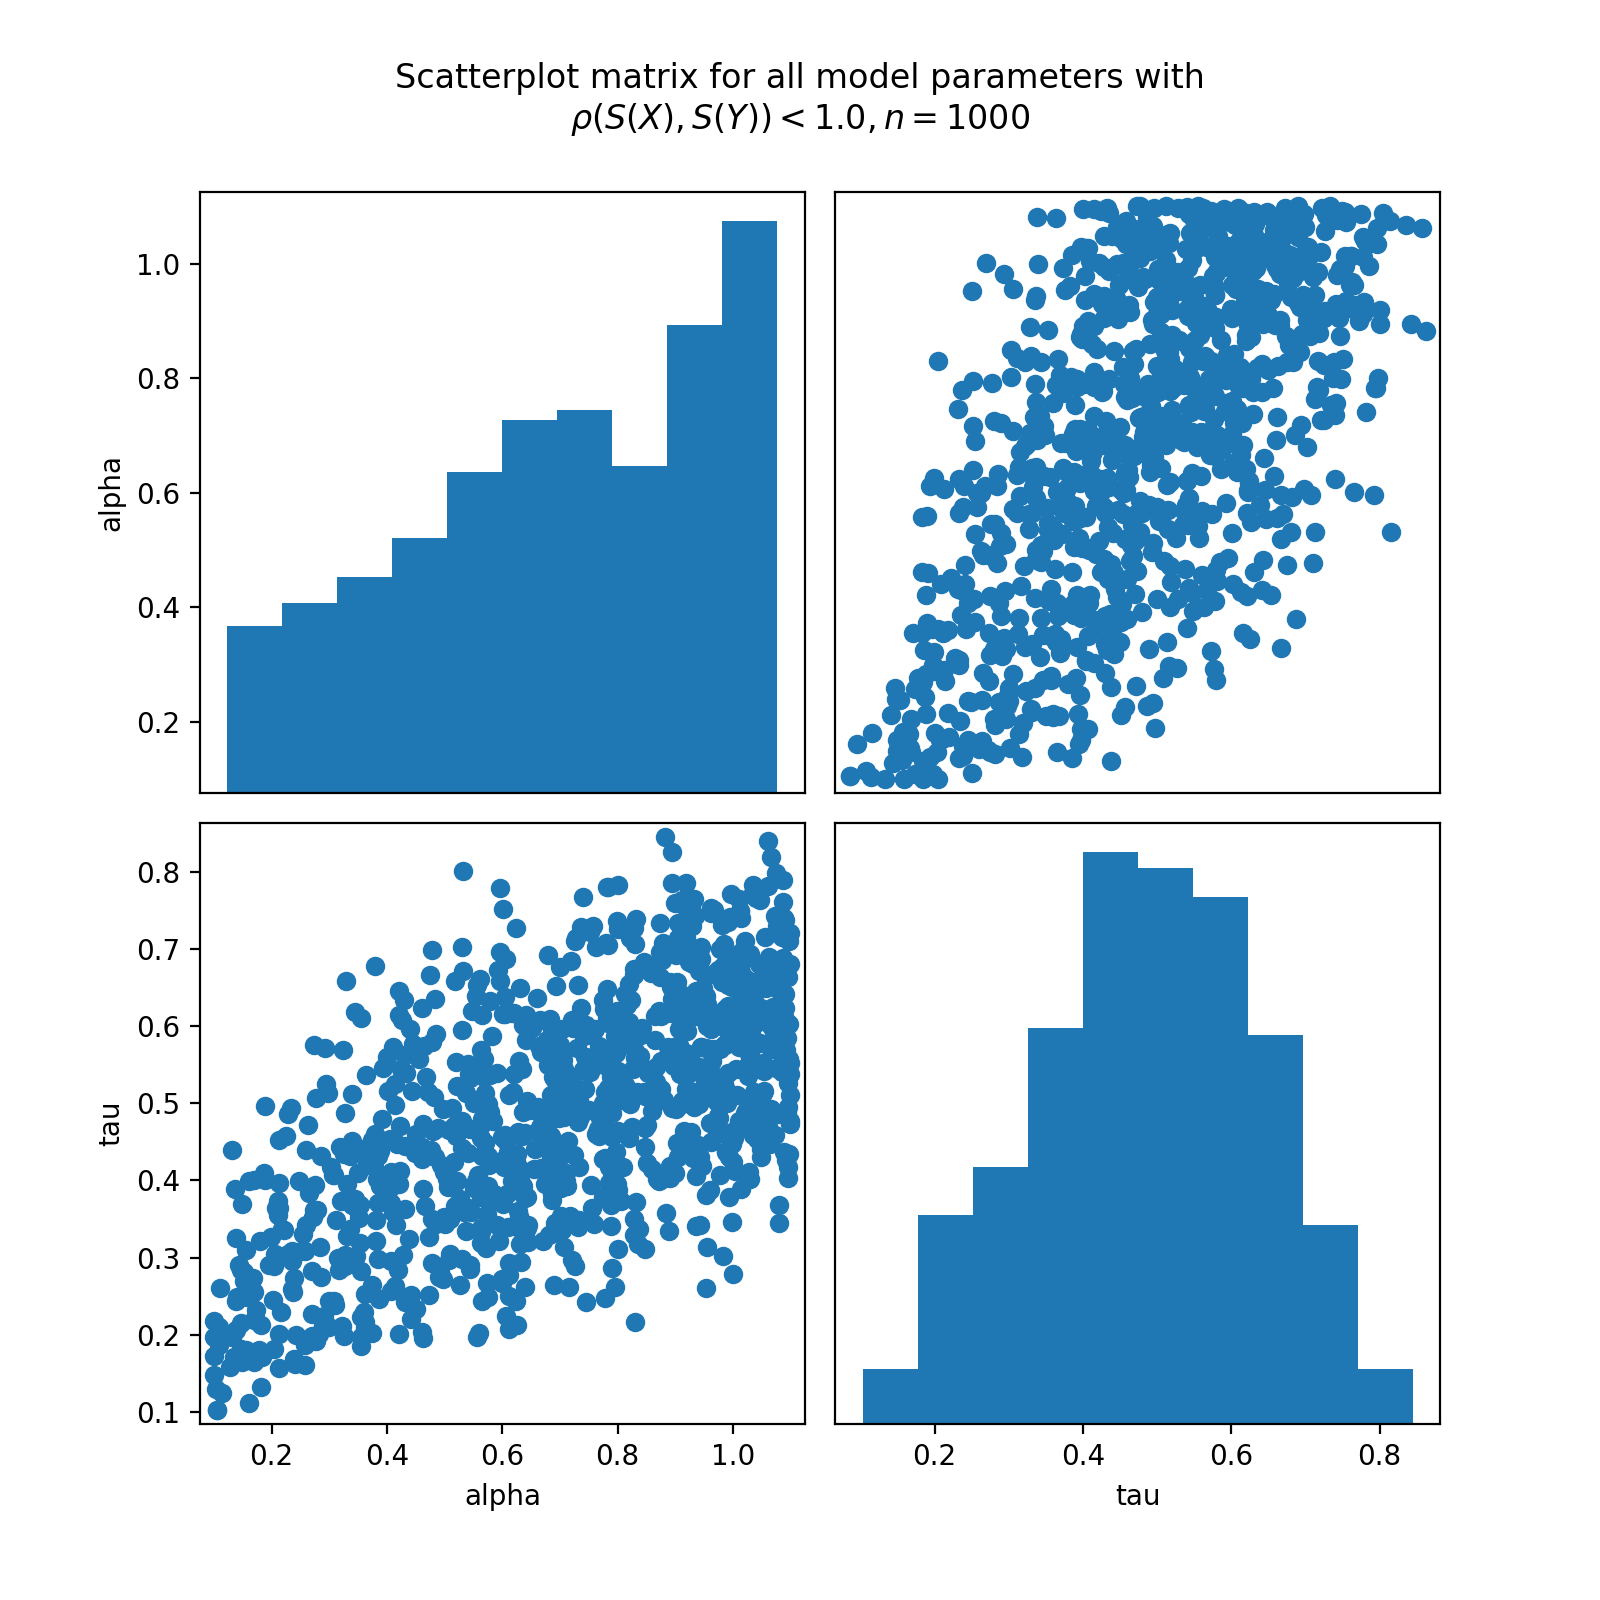

<IPython.core.display.Javascript object>


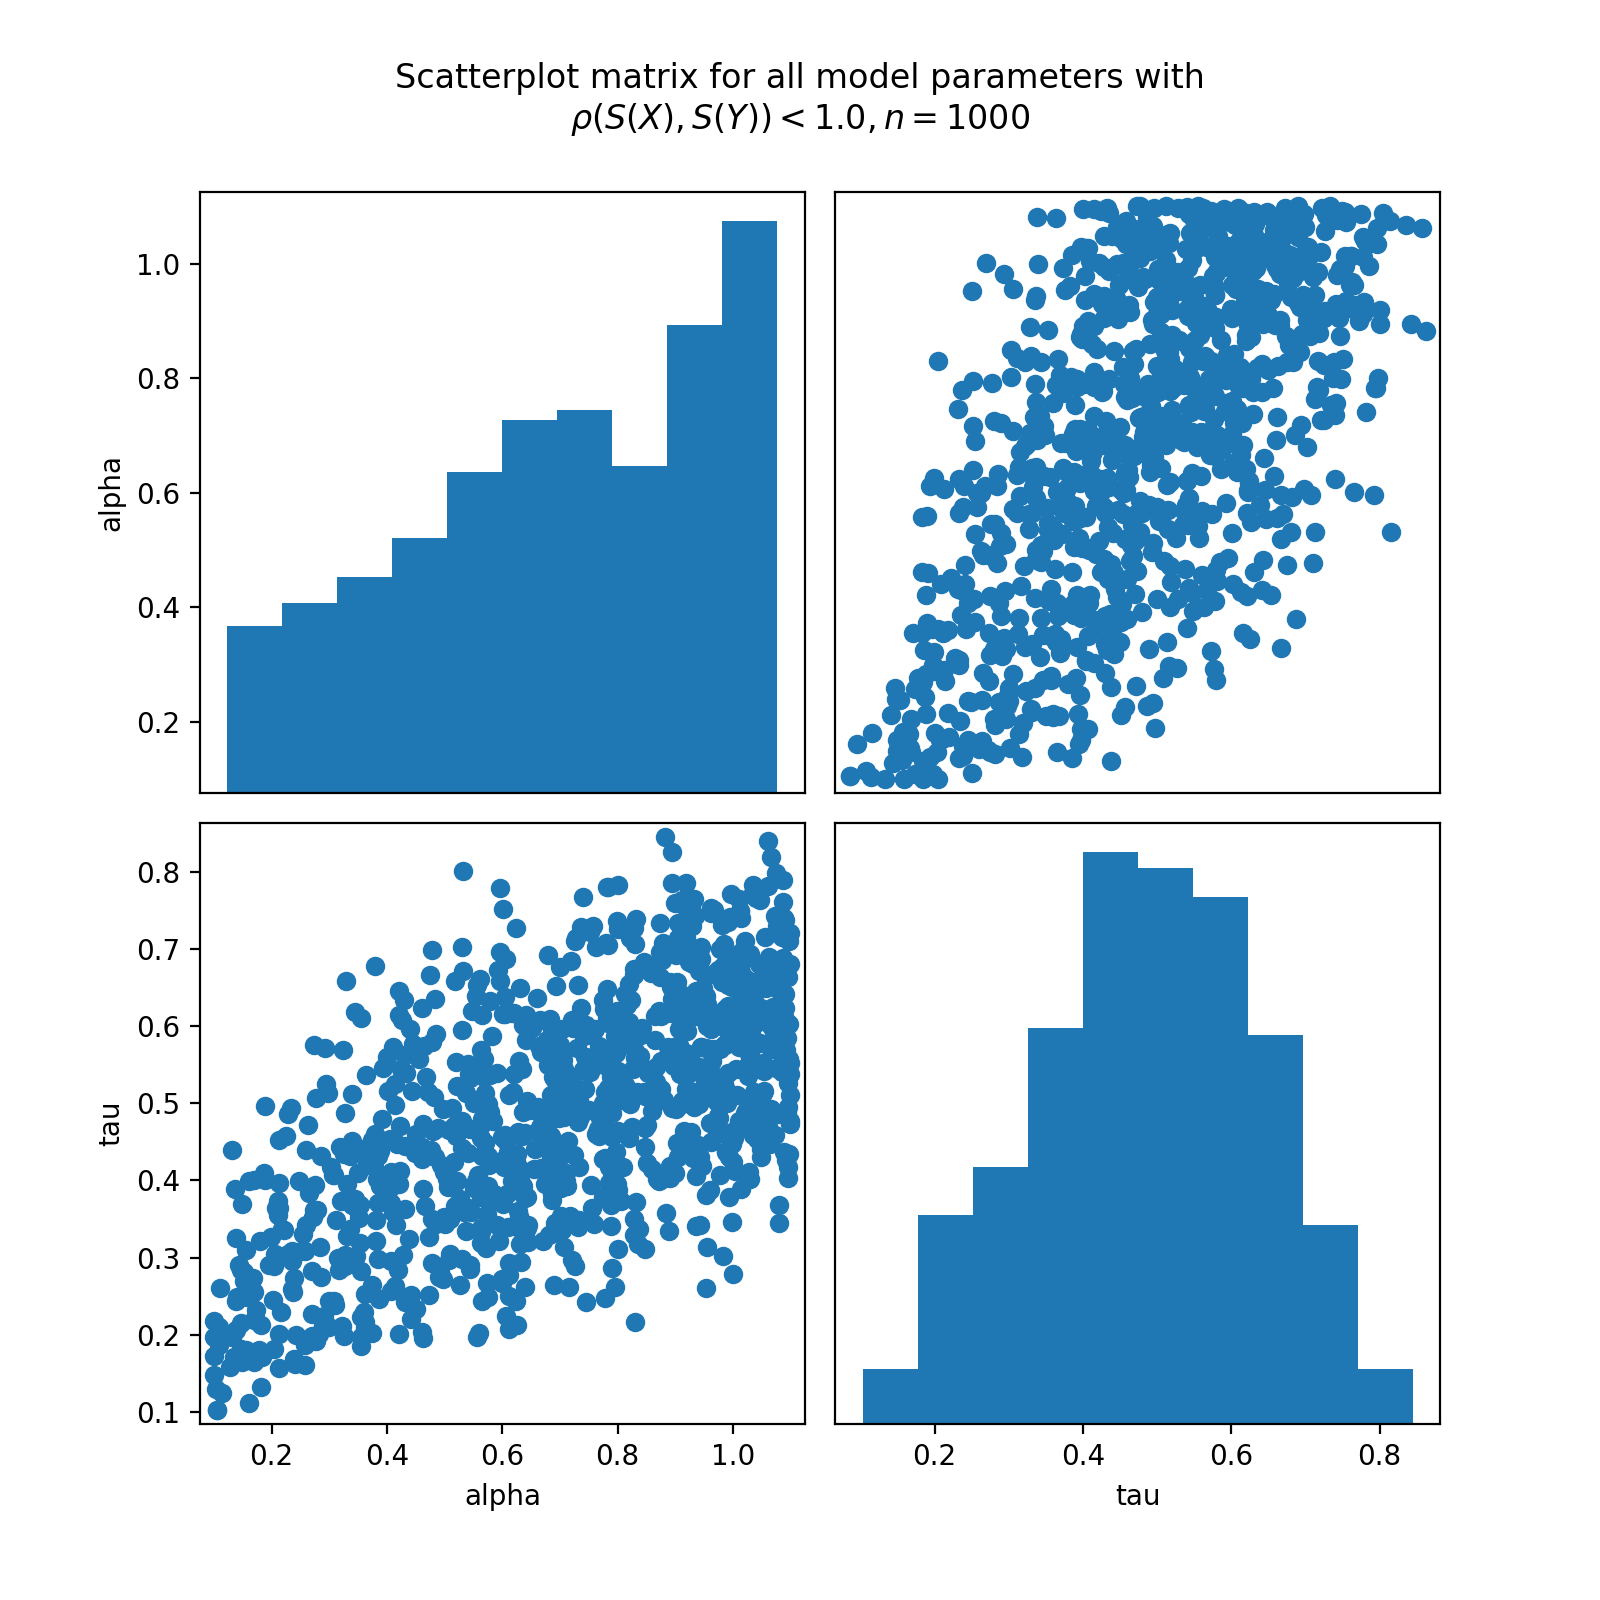

In [22]:
plot_pairs(smc)

In [ ]:
plot_particles(smc)

### ABC with identity

In [ ]:
idendity = lambda x: x

rej = pyabc.RejectionSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=idendity,
                             observation=y0, seed = 1337, verbosity=1)

smc = pyabc.SMCSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=idendity,
                             observation=y0, seed = 1337)


mcmc = pyabc.MCMCSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=idendity,
                             observation=y0, seed = 1337)



In [ ]:
rej.sample(nr_samples=1000, threshold=2)

In [ ]:
smc.sample(nr_samples=1000, thresholds=np.linspace(5, 2, 5))

In [ ]:
mcmc.sample(nr_samples=1000, threshold=2, step_size = [0.1, 0.1])

In [ ]:
plot_marginals(rej, kde=True, normed=True)
plot_marginals(smc, kde=True, normed=True)
plot_marginals(mcmc, kde=True, normed=True)

### ABC with classifier LDA

In [15]:
def simulator(alpha, tau, delta=0, batch=10):
    m = 20
    return_val = np.zeros((batch, m))
    
    for run in range(batch):
        infected_hosts = np.array([[1]]) # list of haplotypes holding infectious hosts, we always start with one infected patient
        limit_exceeded = False
        round = 0

        while np.sum(infected_hosts) <= m and not limit_exceeded:
            round += 1

            #reset if all died
            if np.sum(infected_hosts) == 0:
                infected_hosts = np.array([[1]])

            # for each haplotype
            for cell in infected_hosts:
                # for each infectious host
                if cell[0] == 0:
                    continue
                for host in range(cell[0]):
                    # one of three things happen: transmission, mutation or recovery/death
                    event = np.random.rand()
                    # if he dies -> no more action possible
                    if event < delta:
                        cell -= 1

                        continue

                    # otherwise, he can infect others or/and mutate
                    event = np.random.rand()
                    if event < alpha:
                        if np.sum(infected_hosts) == m:
                            limit_exceeded = True
                            break
                        else:
                            cell += 1


                    event = np.random.rand()
                    if event < tau and cell[0] > 1:
                        new_cell = [1]
                        cell -= 1
                        infected_hosts = np.vstack((infected_hosts, new_cell))



                if limit_exceeded:
                    break

        for i in range(len(infected_hosts), m):
            infected_hosts = np.vstack((infected_hosts, [0]))
        
        return_val[run] = np.array(sorted(infected_hosts, reverse=True))[:m].flatten()

    return np.atleast_3d(return_val)

In [16]:
simulator(alpha, tau)

array([[[  3.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  0.],
        [  0.]],

       [[  5.],
        [  2.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  7.],
        [  3.],
        [  2.],
        [  2.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  2.],
        [  2.],
  

In [23]:
idendity = lambda x: x

rej = pyabc.RejectionSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=idendity, distance='lda',
                             observation=y0, seed = 1337, verbosity=2)

smc = pyabc.SMCSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=idendity, distance='lda',
                             observation=y0, seed = 1337)


mcmc = pyabc.MCMCSampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             summaries=idendity, distance='lda',
                             observation=y0, seed = 1337)

#abcde = pyabc.ABCDESampler(priors=[prior_alpha, prior_tau], simulator=simulator, 
                             #summaries=idendity, distance='lda',
                             #observation=y0, seed = 1337)

KeyError: "Passed argument lda is not a valid distance function. Choose from dict_keys(['euclidean'])."

In [24]:
rej.sample(nr_samples=1000, threshold=2)

Rejection sampler started with threshold: 2 and number of samples: 1000


KeyboardInterrupt: 